# Grade: 100 points

# Assignment 02: Classification with Ridge, LASSO, and Feedforward Neural Networks

## Instructions

#### Follow these steps before submitting your assignment :

1. Complete the notebook.

2. Make sure all plots have axis labels.

3. Once the notebook is complete, `Restart` your kernel by clicking 'Kernel' > 'Restart & Run All'.

4. Fix any errors until your notebook runs without any problems.

5. Please note, a random seed of 42 needs to be set to ensure the reproducability of the results -- *DO NOT* change this random seed. **If you call additional functions that are based on random number generators, you will need to define their seed to 42 as well**.

6. Make sure to reference all external code and documentation used.

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, roc_curve, confusion_matrix
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Suppress overflow warnings from sklearn/numpy
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(over='ignore')

sns.set(style='whitegrid', context='notebook')

#Check device for NN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Q1 - Data Loading and Exploration

[This Kaggle dataset](https://www.kaggle.com/competitions/titanic) contains data on passengers of the famous Titanic disaster. The task is to examine and predict what sorts of people were more likely to survive using data on their name, age, gender, socio-economic class, etc.

#### 1. Loading our Data
Load the train and test data into a pandas dataframe and display the first few rows using ``.head()``

In [249]:
#Q1.1
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

# Display the first 3 rows of each dataframe
print("Training data:")
display(df_train.head(3))
print("Test data:")
display(df_test.head(3))

Training data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Test data:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


#### 2. Checking for Null Values
Check for null values in the training data using ``.isnull().sum()``

In [250]:
#Q1.2
print("Missing values in training data:")
display(df_train.isnull().sum())
print("Missing values in test data:")
display(df_test.isnull().sum())

Missing values in training data:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in test data:


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### 3. Visualizing Null Values

Create a seaborn heatmap that displays all of the null data using ``sns.heatmap(train.isnull(), cbar=False)`` to get a visual representation on how much data is missing for each variable.

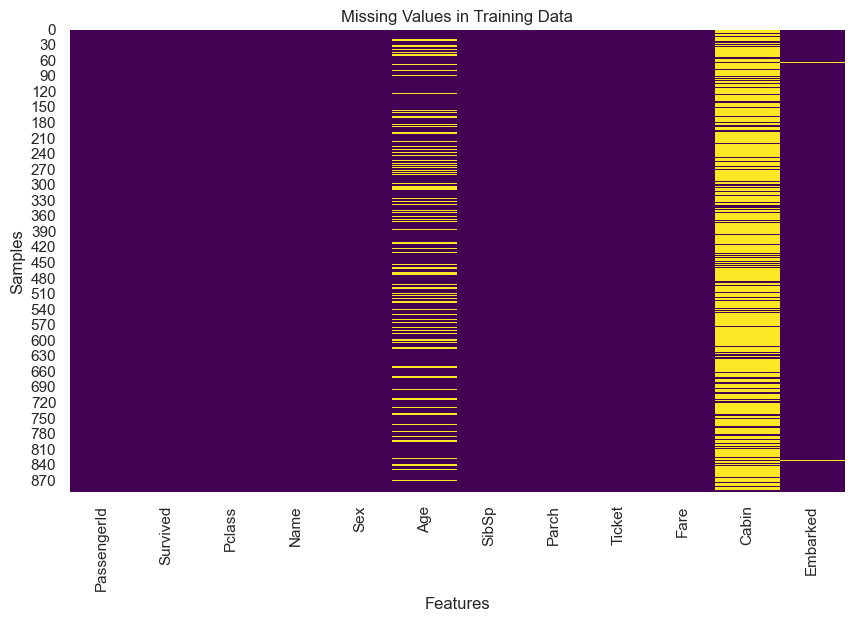

In [251]:
#Q1.3
plt.figure(figsize=(10, 6))
sns.heatmap(df_train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Training Data')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

#### 4a. Visualizing Survival vs. Sex

Create a seaborn barplot that compares 'Survival Rate by Sex', where x is 'Sex' and y is 'Survived' from the training data.

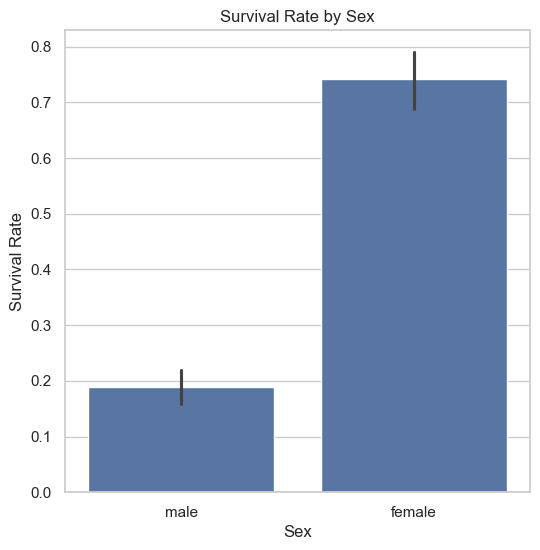

In [252]:
#Q1.4a
plt.figure(figsize=(6, 6))
sns.barplot(x='Sex', y='Survived', data=df_train)
plt.title("Survival Rate by Sex")
plt.xlabel("Sex")
plt.ylabel("Survival Rate")
plt.show()

#### 4b. Visualizing Survival vs. Passenger Class
Create another barplot for 'Survival Rate by Passenger Class' (the `Pclass` variable).

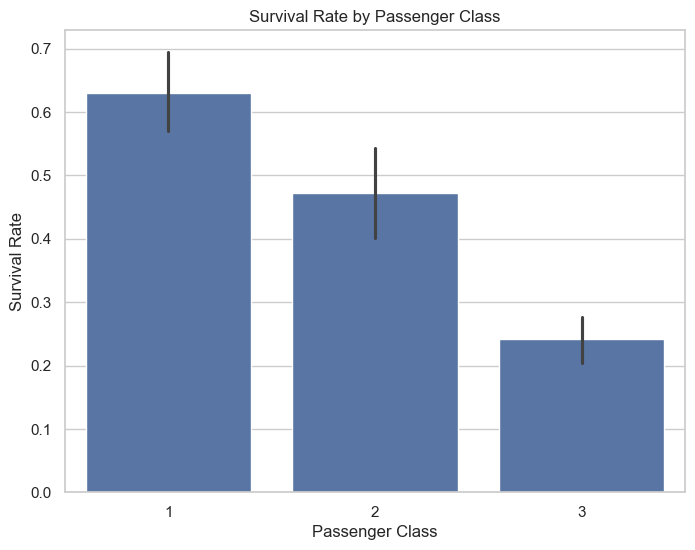

In [253]:
#Q1.4b
plt.figure(figsize=(8, 6))
sns.barplot(data=df_train, x='Pclass', y='Survived')
plt.title("Survival Rate by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.show()

#### 5. Visualizing Age Distribution by Survival

Create a seaborn a stacked histogram for 'Age Distribution by Survival'. x is 'Age', and one histogram should be for 'Survived'=0, and the other for 'Survived'=1. Use a bin size of 20.

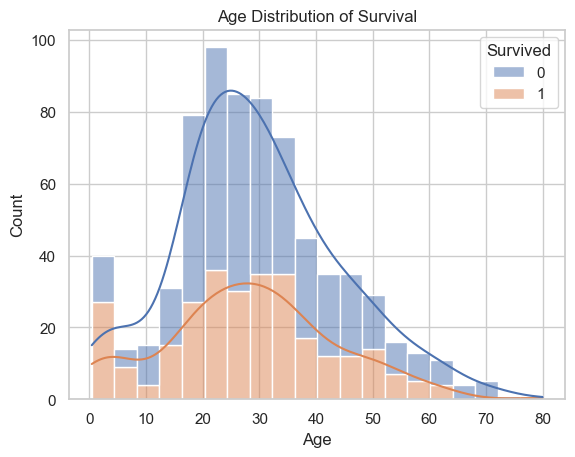

In [254]:
#Q1.5
sns.histplot(data=df_train, x='Age', hue='Survived', bins=20, kde=True, multiple="stack")
plt.title("Age Distribution of Survival")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

#### 6. Feature Correlation

Create a seaborn heatmap: 'Feature Correlation Heatmap' which displays only numeric variables. The result should contain 7 variables. Although we will not be doing so in this assignment, noting which variables are most highly correlated can inform our decisions on feature engineering. We will discuss this further in assignment 3.

In [255]:
#Q1.6

# Q2 - Feature Engineering

In this section, you will engineer new features from the Titanic dataset to help your model capture more meaningful relationships.

Use **pandas** functions such as:
- `.apply()`
- `.replace()`
- `.groupby()`
- `.median()`
- `.fillna()`
- `.map()`
- `.get_dummies()`
- `.astype()`

Follow the outline below and implement each transformation step-by-step.


#### 1. Extract Titles from Passenger Names
Each passenger’s `Name` contains a title (e.g., *Mr.*, *Mrs.*, *Miss.*, *Dr.*, etc.).  
- Use `.apply()` with a helper function to extract each passenger’s title from the `Name` column.  
- Combine less common titles ('Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona') into a single category called `"Rare"`.  
  - You can do this efficiently with `.replace()`.

In [256]:
import re

# Extract Title from Name
def extract_title(name):
    m = re.search(r", (.*?)\\.", name)
    return m.group(1) if m else 'Unknown'

#Q2.1

#### 2. Create Family-Based Features
We can capture social context by adding two new features:
- **`FamilySize`**: total number of family members aboard (siblings/spouses + parents/children + 1 for the passenger).  
- **`IsAlone`**: binary indicator (`1` if alone, `0` otherwise).  

To do this:
- Use arithmetic operations on existing columns (`SibSp`, `Parch`) to create `FamilySize`.  
- Create `IsAlone` using a boolean condition and then convert it to an integer with `.astype(int)`.

In [257]:
#Q2.2

#### 3. Impute Missing Ages
Instead of using a single median for all passengers, compute a **median Age per Title**.  
Then fill in missing Age values using that median for the passenger’s title group.

You’ll need to:
- Use `.groupby()` on the `Title` column and compute `.median()` for `Age`.  
- Use `.apply()` (with a `lambda` function) to fill in missing `Age` values row by row.

In [258]:
#Q2.3

#### 4. Fill Missing Fares
Fill missing `Fare` values with the overall median fare of the dataset using `.fillna()`.

In [259]:
#Q2.4

#### 5. Encode Categorical Variables
Machine learning models need numeric features. Convert categorical features into numeric form:
- Convert `Sex` into 0/1 values using `.map()`.  
- One-hot encode `Embarked` into dummy variables (e.g., `Embarked_C`, `Embarked_Q`, `Embarked_S`) using `pd.get_dummies()` with the `columns` argument.

In [260]:
#Q2.5

#### 6. Define Your Feature Set
Create your final feature matrix `X` and label vector `y`.  
Select a combination of numerical and engineered features (e.g., `Pclass`, `Sex`, `Age`, `Fare`, `FamilySize`, `IsAlone`, `Embarked`(_C, _Q, _S) columns).

Use `X.head()` to verify your final dataset looks correct.

In [261]:
#Q2.6

# Q3 - Train/Test Split and Feature Scaling

Now that you’ve finished feature engineering, it’s time to prepare the data for modeling.  
This step ensures that your model generalizes well and that all numeric features are on a similar scale.


#### 1. Split the Data
Use the **`train_test_split()`** function from `sklearn.model_selection` to divide your data into:
- **Training set (80%)**
- **Testing set (20%)**

Make sure to:
- Use the `stratify` parameter to preserve the class balance of the target variable (`y`).
- Set a fixed `random_state` so results are reproducible.

In [262]:
#Q3.1

#### 2. Scale the Numeric Features
Feature scaling helps models converge faster and prevents some features from dominating others.

- Use `StandardScaler` from `sklearn.preprocessing` to **standardize** numeric columns such as `Age`, `Fare`, and `FamilySize`.
- Remember to **fit the scaler only on the training data** and then **transform both** the training and test sets.
  - Functions to use: `.fit()` and `.transform()`
- Overwrite the scaled columns in both `X_train` and `X_test`.

In [263]:
#Q3.2

#### 3. Prepare Data for PyTorch
PyTorch expects input data as floating-point numbers (`float32`).  
Also, boolean columns (`True`/`False`) need to be converted to numeric values (1.0 and 0.0).

Use **`.astype(np.float32)`** on both `X_train` and `X_test` to ensure all features are numeric and compatible with tensors.

In [264]:
#Q3.3 Cast bools to 1.0 for true, and 0.0 for false

# Q4 - Training LASSO and Ridge


#### 1. Define the Models
Create two logistic regression models:
- **LASSO (L1 Regularization):**
  - Use the parameter `penalty='l1'`
  - Requires the `solver='liblinear'`
- **Ridge (L2 Regularization):**
  - Use the parameter `penalty='l2'`
  - A good solver choice is `'lbfgs'`
- Set `max_iter` high enough (e.g., 1000) to ensure convergence.


In [265]:
#Q4.1

#### 2. Train (Fit) Each Model
Use the `.fit()` method to train both models on your **training data** (`X_train`, `y_train`).

In [266]:
#Q4.2

#### 3. Make Predictions
Use `.predict_proba()` on the **test set** to get predicted probabilities for the positive class (`Survived = 1`).

You’ll then:
- Extract the second column (the probability of class 1)
- Convert these probabilities to binary predictions (`0` or `1`) using a threshold of 0.5  
  - You can do this using array comparison and `.astype(int)`

Predict 1 if probability > 0.5 else predict 0.

In [267]:
#Q4.3

Run the following for evaluation metrics for both of these models.

In [268]:
# Metrics
def evaluate_model(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    print(f"{name} → Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {auc:.4f}")

evaluate_model('LASSO Logistic Regression', y_test, lasso_preds, lasso_probs)
evaluate_model('Ridge Logistic Regression', y_test, ridge_preds, ridge_probs)

# Coefficient comparison
coeff_df = pd.DataFrame({
'Feature': features,
'LASSO Coeff': lasso.coef_[0],
'Ridge Coeff': ridge.coef_[0]
})

coeff_df_melted = coeff_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')
plt.figure(figsize=(10,6))
sns.barplot(data=coeff_df_melted, x='Feature', y='Coefficient', hue='Model')
plt.xticks(rotation=45)
plt.title('Feature Coefficients: LASSO vs Ridge')
plt.show()

NameError: name 'y_test' is not defined

# Q5 - Training a Neural Network

Convert the datasets to tensors for Pytorch.

In [ ]:
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)

Define our NN Model.

In [ ]:
class TitanicNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = TitanicNet(X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#### 1. Define your Training Loop

Inside your training loop, for each batch of data from the DataLoader, you’ll need to perform the core operations that allow your neural network to learn.  

At a high level, each batch should follow this sequence:

1. **Reset accumulated gradients** — before processing a new batch, clear any gradients stored from the previous iteration using the appropriate optimizer method.  
2. **Forward pass** — pass the batch of input data through the model to obtain predicted outputs (often called *logits*).  
3. **Compute the loss** — use your chosen loss function (*criterion* in the cell above) to compare the predictions with the actual target labels.  
4. **Backpropagation** — compute gradients of the loss with respect to the model’s parameters.  
5. **Parameter update** — use the optimizer to apply those gradients and update the model weights.

Each of these steps corresponds to a single PyTorch function call, and they must occur in this exact order for the model to train correctly.


In [ ]:
num_epochs = 50
train_losses, train_accs = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        #Q5.1 Add training code here

        total_loss += loss.item() * xb.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        total_correct += (preds == yb).sum().item()
        total += xb.size(0)

        train_loss = total_loss / total
        train_acc = total_correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}")

Plot training loss and accuracy.

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

Plot training loss and accuracy again, but smoothed so we can see overall trends more easily.

In [ ]:
window = 100  # moving average window
smoothed_acc = pd.Series(train_accs).rolling(window).mean()
smoothed_loss = pd.Series(train_losses).rolling(window).mean()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(smoothed_loss, label=f'Train Loss (avg {window})')
plt.title('Training Loss (Smoothed)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(smoothed_acc, label=f'Train Accuracy (avg {window})')
plt.title('Training Accuracy (Smoothed)')
plt.legend()
plt.show()

Report evaluation metrics just like we did for LASSO and Ridge.

In [ ]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t.to(device)).cpu().numpy().flatten()

probs = 1 / (1 + np.exp(-logits))
preds = (probs > 0.5).astype(int)

acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, probs)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

#### 2. ROC Curve (Receiver Operating Characteristic)

The **ROC curve** shows the trade-off between the **True Positive Rate (TPR)** and the **False Positive Rate (FPR)** at various classification thresholds.

- Use `roc_curve()` from `sklearn.metrics` to calculate the `fpr` and `tpr` values.
- Plot these values using `matplotlib.pyplot` to visualize your model’s ability to distinguish between classes.
- Add an **AUC (Area Under the Curve)** score to your plot legend to summarize overall performance.

A higher AUC (closer to 1.0) means your model is better at distinguishing survivors from non-survivors.

Include:
- `plt.plot()` for the ROC line  
- Axis labels (`plt.xlabel`, `plt.ylabel`)  
- A title and legend for clarity


In [ ]:
#Q5.2

#### 3. Confusion Matrix

A **confusion matrix** shows how many predictions were correct versus incorrect for each class.

- Use `confusion_matrix()` from `sklearn.metrics` to generate the matrix.
- Then use `seaborn.heatmap()` to visualize it in an easy-to-read grid format.
- Label the axes to clearly indicate which side represents predicted vs. actual values.

Set `annot=True` to display the numbers inside the boxes and use a color map (e.g., `'Blues'`) for better contrast.

In [ ]:
#Q5.3